### Download MNIST

In [2]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

# datos y labels. Los datos son una fila por ejemplo. 
# Cada fila tiene 784 features o columnas o pixeles (28x28). Estos tienen valores de 0 a 255
X, y = mnist["data"], mnist["target"]

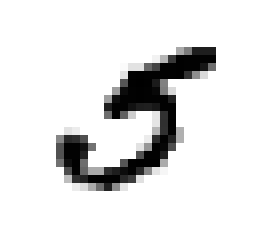

In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000] # tomo un ejemplo cualquiera
some_digit_image = some_digit.reshape(28,28) # convierto la fila en una matriz de 28x28 (784)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# el conjunto ya está dividido en train y test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

# los mezclo para que despues los folds me vengan menos uniformes
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Reconociendo el número 5

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

print("vectores binarios", y_train_5, y_test_5)

vectores binarios [ True False False ...,  True False False] [False False False ..., False False False]


In [11]:
from sklearn.linear_model import SGDClassifier # stochastic gradient descent

clf = SGDClassifier(random_state=42)
clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [14]:
print(clf.predict(some_digit))
some_digit2 = X[38000] # tomo un ejemplo cualquiera
print(clf.predict(some_digit2))

[ True]
[False]


/home/chelis/.virtualenvs/handson/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/chelis/.virtualenvs/handson/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### Cross validation

In [15]:
from sklearn.model_selection import cross_val_score
# cv=3 3-folds.
cross_val_score(clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9622 ,  0.95975,  0.96315])

### Confusion matrix

Accuracy no es el mejor metodo para medir si predice bien o no, porque depende de que tan sesgada sea la muestra y lo que esté tratando de predecir. Por ejemplo si hago un classifier que encuentre los "NO 5" y a todo digo que no es un 5, la accuracy en este dataset va a ser de alredededor del 90%. Las matrices de confusion son mejores. Esto mide cuantas veces algo fue clasificado erróneamente.

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, X_train, y_train_5, cv=3)
print(y_train_pred)

from sklearn.metrics import confusion_matrix 
# filas = clase verdadera. Columna= clase predicha. Deberia ser diagonal
confusion_matrix(y_train_5, y_train_pred)

# precision = #proporción de veces que predije clase X cuando era de verdad clase X = TP/(TP + FP)
# recall = proporción de veces que logro identificar a la clase X = TP/(TP + FN)

from sklearn.metrics import precision_score, recall_score

print("precision:", precision_score(y_train_5, y_train_pred))
print("recall:", recall_score(y_train_5, y_train_pred))

# F1 score = relacion entre precision y recall o harmonic mean. Esta medida solo sera alta si ambas metricas son altas

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

[ True False False ..., False False False]
precision: 0.816285193437
recall: 0.743405275779


0.77814249855184403

#### no puedo modificar el threshold para definir que algo es positivo directamente con sciklearn, tengo que dar unas vueltas

[ 38527.7582954]
[ True]
[False]


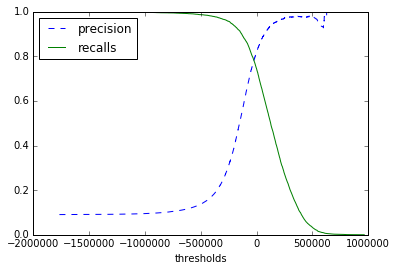

In [30]:
y_scores = clf.decision_function([some_digit])
print(y_scores)
threshold = 0
print(y_scores > threshold)
threshold = 40000
print(y_scores > threshold)

y_scores = cross_val_predict(clf, X_train, y_train_5, cv=3, method="decision_function")
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_prt(p, r, t):
    plt.plot(t, p[:-1], 'b--',label= "precision")
    plt.plot(t, r[:-1], 'g-',label= 'recalls')
    plt.xlabel("thresholds")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_prt(precisions, recalls, thresholds)

In [34]:
x_train_pred_90 = (y_scores > 72000)
print(x_train_pred_90)
print(precision_score(y_train_5, x_train_pred_90))
print(recall_score(y_train_5, x_train_pred_90))

# pero el recall es muy bajo. Esto significa que tengo muchos falsos negavos. O sea, muchos 5 que dije que no eran 5.

[ True False False ..., False False False]
0.900327689787
0.60819037078


In [36]:
# ROC AUC

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))
print(roc_auc_score(y_train_5, x_train_pred_90))

0.962675641254
0.80075140848


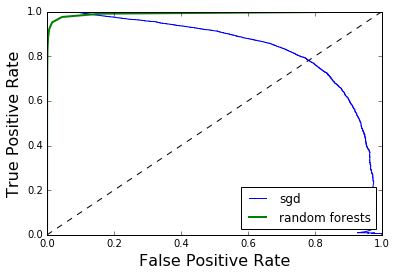

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas[:,1] # score= proba of possitive class

from sklearn.metrics import roc_curve
fpr_forest, tpr_forest, thr_forest = roc_curve(y_train_5, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.plot(precisions, recalls, label="sgd")
plot_roc_curve(fpr_forest, tpr_forest, "random forests")
plt.legend(loc="lower right")

In [46]:
print(roc_auc_score(y_train_5, y_scores_forest))
print(roc_auc_score(y_train_5, y_scores))

0.991622185806
0.962675641254
